In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate,TimeDistributed
from keras import optimizers

In [64]:
df = pd.read_csv("infyns_2711.csv")
df = df.drop("Date", axis=1)
df = df[['High', 'Low', 'Close', 'Volume', 'Open']]
df = df.dropna(how='any',axis=0) 
#print(y_scaler.data_min_,y_scaler.data_max_)
df.head()

,High,Low,Close,Volume,Open
0,1.58203,1.54297,1.54316,665600.0,1.54297
1,1.57031,1.54492,1.55742,921600.0,1.56230
2,1.56055,1.54502,1.55469,768000.0,1.54502
3,1.58008,1.56250,1.56250,921600.0,1.58008
4,1.56836,1.54307,1.56582,819200.0,1.54307


In [65]:
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
df[['High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['High', 'Low', 'Close', 'Volume']])
df[['Open']]=y_scaler.fit_transform(df[['Open']]) 
df.head()

,High,Low,Close,Volume,Open
0,0.000018,0.000000e+00,0.000000,0.002406,0.000000e+00
1,0.000008,1.719566e-06,0.000012,0.003332,1.640280e-05
2,0.000000,1.807749e-06,0.000010,0.002776,1.739563e-06
3,0.000016,1.722211e-05,0.000017,0.003332,3.149033e-05
4,0.000007,8.818287e-08,0.000020,0.002962,8.485672e-08


In [66]:
#li=[]
#for i in range(1,11):
#    li.append([i,i**2,2*i,3*i,100*i])
#df=pd.DataFrame(li, columns=['high', 'low', 'close', 'volume', 'open'])
#df.head(10)

In [67]:
time_steps=10

In [68]:
df=df.to_numpy()

In [69]:
def split_sequences(data, time_steps):                                # split a multivariate sequence into samples
    X, y = list(), list()
    for i in range(len(data)):
        endx = i + time_steps                                       # find the end of this sequence
        if endx+4 > len(data):                                      # Break if dataset is over
            break
        seq_x = data[i:endx]
        seq_y = data[endx:endx+3,-1]                                      #Change here to increase time steps to be predicted for the future
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [70]:
X, y = split_sequences(df, time_steps)
print(X.shape, y.shape)

#for i in range(0,1):
#    print(X[i], y[i])

(5892, 10, 5) (5892, 3)


In [71]:
test_split = 0.8 
n = int(X.shape[0] * test_split)

# splitting the dataset up into train and test sets

X_train = X[:n]
y_train = y[:n]

X_test = X[n:]
y_test = y[n:]


In [72]:
n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(time_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(15, activation='relu',input_shape=(time_steps, n_features)))
model.add(Dense(3))                              #TimeDistributed(), return sequences
model.compile(optimizer='adam', loss='mse')

In [73]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 10, 50)            11200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 15)                3960      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 48        
Total params: 15,208
Trainable params: 15,208
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, shuffle=True, validation_split=0.1)

Epoch 1/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0062 - val_loss: 7.2113e-04
Epoch 2/20
133/133 [==============================] - 1s 9ms/step - loss: 2.1152e-04 - val_loss: 4.3852e-04
Epoch 3/20
133/133 [==============================] - 1s 9ms/step - loss: 1.8742e-04 - val_loss: 4.2761e-04
Epoch 4/20
133/133 [==============================] - 1s 9ms/step - loss: 1.7095e-04 - val_loss: 2.7549e-04
Epoch 5/20
133/133 [==============================] - 1s 8ms/step - loss: 1.5703e-04 - val_loss: 2.3840e-04
Epoch 6/20
133/133 [==============================] - 1s 10ms/step - loss: 1.4087e-04 - val_loss: 2.4900e-04
Epoch 7/20
133/133 [==============================] - 1s 8ms/step - loss: 1.3539e-04 - val_loss: 3.5329e-04
Epoch 8/20
133/133 [==============================] - 1s 8ms/step - loss: 1.2650e-04 - val_loss: 5.1299e-04
Epoch 9/20
133/133 [==============================] - 1s 9ms/step - loss: 1.2171e-04 - val_loss: 2.1531e-04
Epoch 10/20
133/133 [=========

In [75]:
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

37/37 [==============================] - 0s 3ms/step - loss: 0.0015
0.0014675630955025554


In [76]:
y_test_predicted = model.predict(X_test)
real_mse = np.mean(np.square(y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test)) * 100
print(scaled_mse)

0.23371083804988105


In [77]:
y_test_predicted = y_scaler.inverse_transform(y_test_predicted)
test_close_values= y_scaler.inverse_transform(y_test) #if only a single value predicted then y_test.reshape(-1, 1)

In [78]:
test_close_values.shape

(1179, 3)

In [79]:
y_test_predicted.shape

(1179, 3)

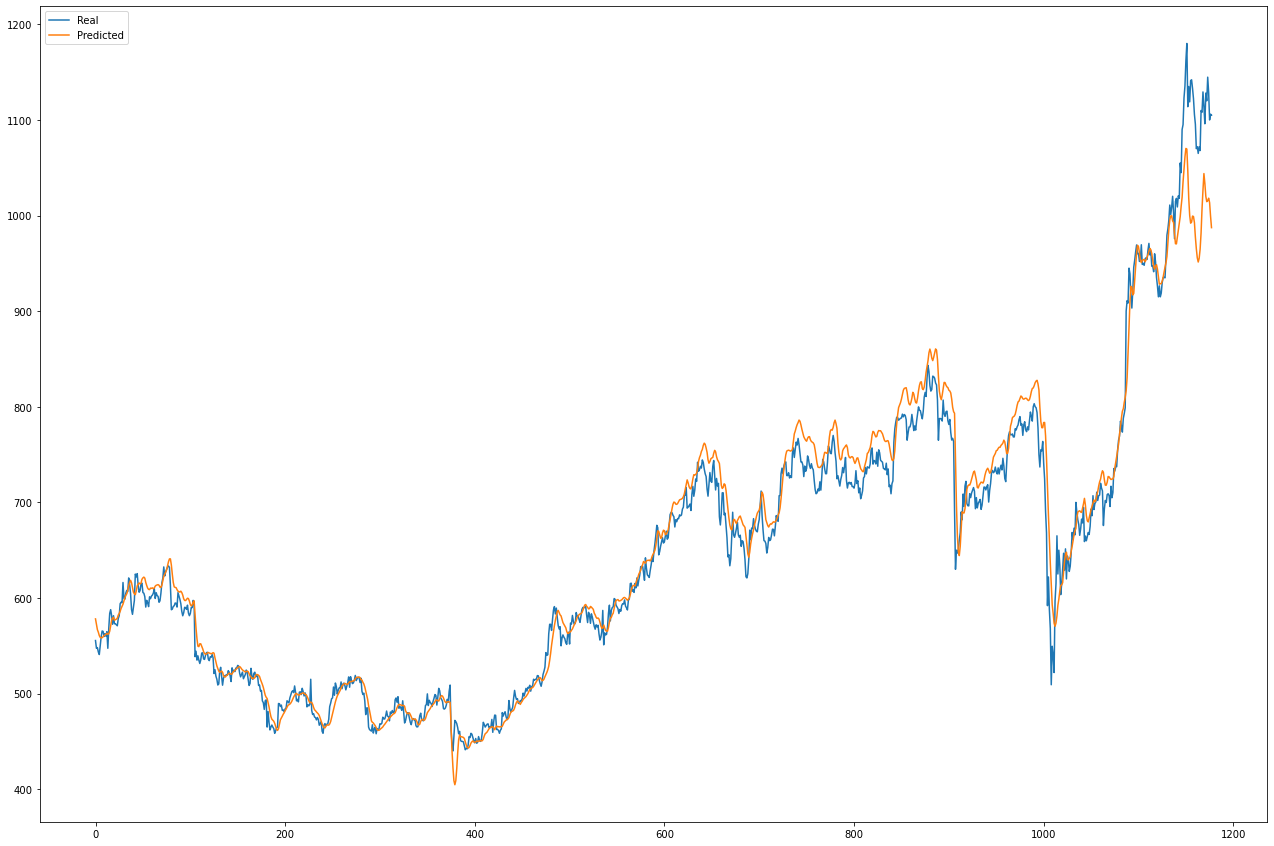

In [80]:
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(test_close_values[start:end,0], label='real')
pred = plt.plot(y_test_predicted[start:end,0], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [81]:
# also getting predictions for the entire dataset, just to see how it performs
y_predicted = model.predict(X)
y_predicted = y_scaler.inverse_transform(y_predicted)
full_close_values=y_scaler.inverse_transform(y) #if only a single value predicted then y.reshape(-1, 1)

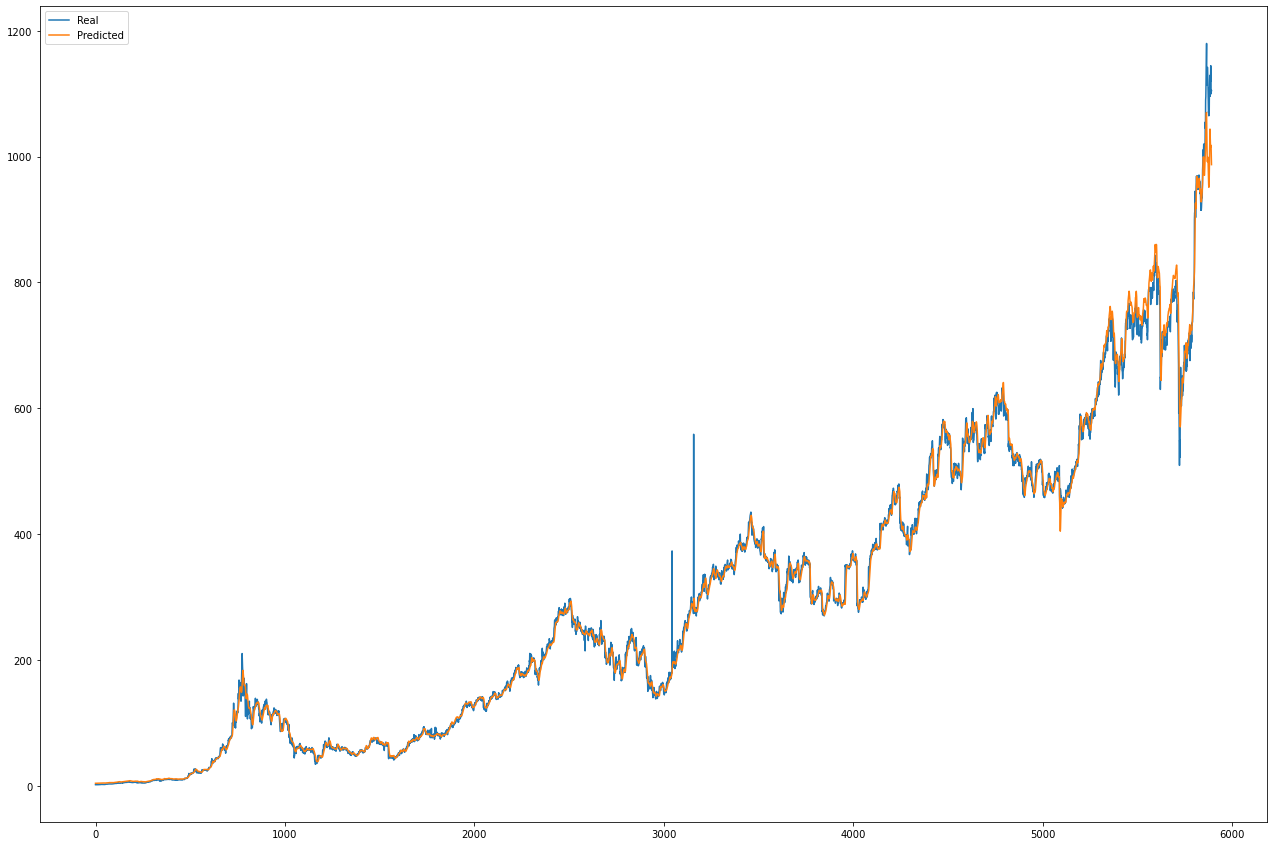

In [82]:
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(full_close_values[start:end,0], label='real')
pred = plt.plot(y_predicted[start:end,0], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [83]:
full_close_values[-1]

array([1145.      , 1137.      , 1119.949951])

In [84]:
y_predicted[-1]

array([989.69135, 861.2338 , 830.2647 ], dtype=float32)

In [85]:
y_scaler.inverse_transform(model.predict(np.array(df[-25:]).reshape(1,25,5)).reshape(-1, 1))

array([[1234.5369 ],
       [ 908.2764 ],
       [ 834.99786]], dtype=float32)